# Titanic

<a href="https://colab.research.google.com/github/saurav-singh321/Flask_ML/blob/main/Titanic%20Survival.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
#Importing necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler

warnings.filterwarnings('ignore')

In [2]:
#loading data
train = pd.read_csv('train_titanic.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Survival 	0 = No, 1 = Yes
pclass 	Ticket class 	1 = 1st, 2 = 2nd, 3 = 3rd
sex 	Sex 	
Age 	Age in years 	
sibsp 	# of siblings / spouses aboard the Titanic 	
parch 	# of parents / children aboard the Titanic 	
ticket 	Ticket number 	
fare 	Passenger fare 	
cabin 	Cabin number 	
embarked 	Port of Embarkation 	C = Cherbourg, Q = Queenstown, S = Southampton

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them. 

### Checking for null values

In [3]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

**[Observation]** - 

We can see that there are null values in `Age`, `Cabin` and `Embarked`

# Features which has nan values

In [4]:
# features with na
train = train.copy()

na_features_train = [features for features in train.columns if (train[features].isna().sum()>0)]

print(na_features_train)
print()

#count of features with na
na_features_train_count = {features:train[features].isna().sum() for features in na_features_train}

print(na_features_train_count)

['Age', 'Cabin', 'Embarked']

{'Age': 177, 'Cabin': 687, 'Embarked': 2}


# Checking if the data is balanced

0    549
1    342
Name: Survived, dtype: int64

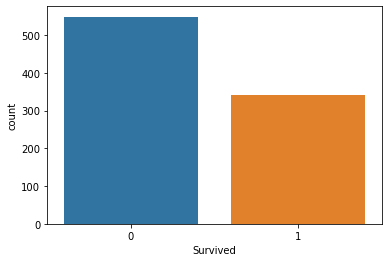

In [5]:
# plotting survival counts
sns.countplot(x='Survived',data=train)
train['Survived'].value_counts()

We can see that more people died

# Numerical variables

In [6]:
train = train.copy()

numerical_features_train = train.select_dtypes(exclude='O').columns

print(numerical_features_train)

train[numerical_features_train]

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500
...,...,...,...,...,...,...,...
886,887,0,2,27.0,0,0,13.0000
887,888,1,1,19.0,0,0,30.0000
888,889,0,3,NaN,1,2,23.4500
889,890,1,1,26.0,0,0,30.0000


## Discrete variables

In [7]:
discrete_numerical_features_train = [features for features in numerical_features_train if len(train[features].unique())<25]

print(discrete_numerical_features_train)
print()

discrete_numerical_features_train_count = {features:len(train[features].unique()) for features in discrete_numerical_features_train}

print(discrete_numerical_features_train_count)

['Survived', 'Pclass', 'SibSp', 'Parch']

{'Survived': 2, 'Pclass': 3, 'SibSp': 7, 'Parch': 7}


3    491
1    216
2    184
Name: Pclass, dtype: int64


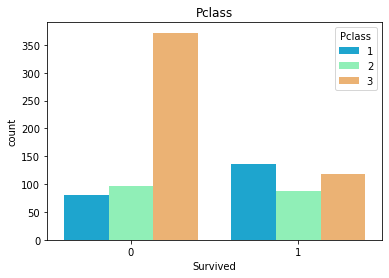

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64


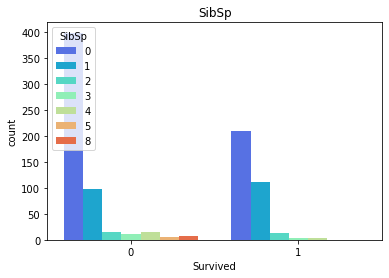

0    678
1    118
2     80
3      5
5      5
4      4
6      1
Name: Parch, dtype: int64


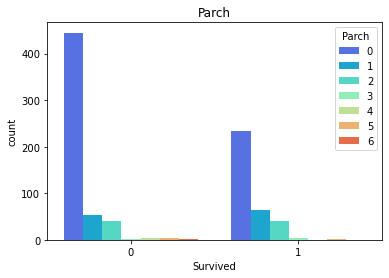

In [8]:
for features in discrete_numerical_features_train:
    if features not in 'Survived': # because it is a target variable
        print(train[features].value_counts())
        sns.countplot(x='Survived',hue=features,data=train,palette='rainbow')
        plt.title(features)
        plt.show()

**[Observation]** - 

`Poor people` died more because `Rich people` paid money and succeed in escaping.

Those people who does not have any `sibling` or `spouse` died more.

Those people who does not have any `parent` or `child` died. 
    
 ### Pclass is an ordinal variable


## Continuous variables

In [9]:
continuous_numerical_features_train = [features for features in numerical_features_train if features not in discrete_numerical_features_train]

print(continuous_numerical_features_train)

['PassengerId', 'Age', 'Fare']


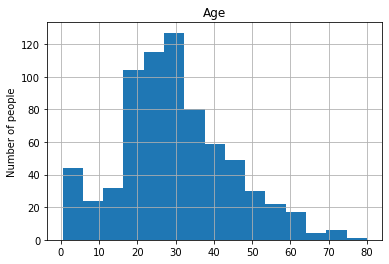

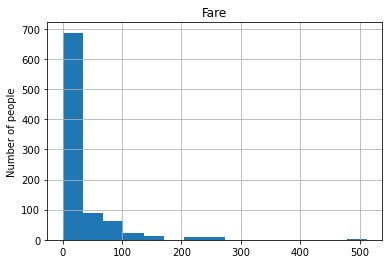

In [10]:
for features in continuous_numerical_features_train:
    if features not in 'PassengerId':
        train[features].hist(bins=15)
        plt.title(features)
        plt.ylabel('Number of people')
        plt.show()

**[Observation]** - 

There are more people of `Age` 26-32.

People who paid `Fare` of 0-25 are more.

# Categorical Variable

In [11]:
categorical_features_train = train.select_dtypes(include='O').columns

print(categorical_features_train)
print()

categorical_features_train_count = {features:len(train[features].unique()) for features in categorical_features_train}

print(categorical_features_train_count)

Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')

{'Name': 891, 'Sex': 2, 'Ticket': 681, 'Cabin': 148, 'Embarked': 4}


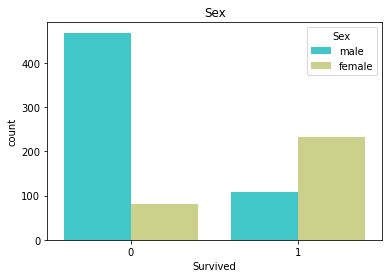

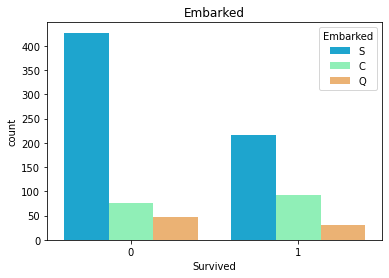

In [12]:
for features in categorical_features_train:
    if features not in 'Name'+'Ticket'+'Cabin':
        sns.countplot(x='Survived',hue=features,data=train,palette='rainbow')
        plt.title(features)
        plt.show()

**[Observation]** - 

`Male` died more then `women`.

People `Embarked` from S have survived more.

In [13]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


No Features are higly correlated. So, we can assume our features to be independent.

# Feature Engineering

First of all I'm dropping some columns because they will not be useful for prediction

In [14]:
train.drop(columns=['PassengerId'],inplace=True)

In [15]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Getting first letter from cabin

In [16]:
#Filling the missing value in cabin as Missing
train['Cabin'].fillna('Missing',inplace = True)

#Taking the first letter of Cabin
train['Cabin'] = train['Cabin'].astype(str).str[0]
labels = train.groupby(['Cabin'])['Survived'].mean().sort_values().index

#Assigning index to to the first letter of Cabin based on the target variable
label_two = {k:i for i,k in enumerate (labels ,0)}

#Making a new column to assign the indexes
train['Cabin_ordinal_label'] = train['Cabin'].map(label_two)
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_ordinal_label
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,M,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,4
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,M,S,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,4
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,M,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,M,S,1
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B,S,6
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,M,S,1
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,C,4


In [17]:
train.corr()['Cabin_ordinal_label']

Survived               0.328063
Pclass                -0.660275
Age                    0.234991
SibSp                 -0.041693
Parch                  0.028468
Fare                   0.425559
Cabin_ordinal_label    1.000000
Name: Cabin_ordinal_label, dtype: float64

We can see that the new column that we have made is `32%` correlated with the target variable.

## Getting Titles from name

In [18]:
# By this we get the first thing i.e. the title from the name.
train['Title'] = [i.split(',')[1].split('.')[0].strip() for i in train['Name']]

In [19]:
train['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

The above titles we got.

So, what I am doing is creating a function in which I'm making some titles as rare and correcting some of them.

In [20]:
def title_converted(feature):
    result = ''
    if feature in ['the Countess','Capt','Lady','Sir','Jonkheer','Don','Major','Col', 'Rev', 'Dona', 'Dr']:
        result = 'rare'
    elif feature in ['Ms', 'Mlle']:
        result = 'Miss'
    elif feature == 'Mme':
        result = 'Mrs'
    else:
        result = feature
    return result

In [21]:
#Applying that function to title
train['Title'] = train['Title'].map(title_converted)

In [22]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_ordinal_label,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,M,S,1,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,4,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,M,S,1,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,4,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,M,S,1,Mr


## Filling the missing value

It's understood that the age of `male` and `female` differ so finding the mean of age of male and female both.

In [23]:
mean_age_train = train.groupby(['Sex'])['Age'].mean()

print(mean_age_train)

Sex
female    27.915709
male      30.726645
Name: Age, dtype: float64


Replacing the nan value. Where there is male replace with 31 otherwise 28.

In [24]:
train['Age'] = np.where(train['Sex']=='male',31,28)

Finding the mode of `embarked` to fill its nan value.

In [25]:
train['Embarked'].mode()

0    S
dtype: object

In [26]:
train['Embarked'].fillna(train['Embarked'].mode()[0],inplace=True)

## family size and categorizing it based on family size

I am making a new column by categorzing based on family size like if the family size is less than 1 then it means they are alone.

We are doing this because in Eda we have seen that the those who were alone died more.

In [27]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_ordinal_label,Title
0,0,3,"Braund, Mr. Owen Harris",male,31,1,0,A/5 21171,7.2500,M,S,1,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,28,1,0,PC 17599,71.2833,C,C,4,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,28,0,0,STON/O2. 3101282,7.9250,M,S,1,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,28,1,0,113803,53.1000,C,S,4,Mrs
4,0,3,"Allen, Mr. William Henry",male,31,0,0,373450,8.0500,M,S,1,Mr


In [28]:
train['Family_size'] = train['Parch'] + train['SibSp']+1

In [29]:
#categorizing family size

def category_family_size(size):
    category = ''
    if (size<=1):
        category = 'Loner'
    elif (size <= 4):
        category = 'small'
    else:
        category = 'large'
    return category

In [30]:
train['Family_group'] = train['Family_size'].apply(category_family_size)

## Calculating fare per person and categorizing it based on family size

Fare per person will be calculated by dividing the total fare by family size.

In [31]:
train['Fare_per_person'] = train['Fare']/train['Family_size']

In [32]:
train['Fare_per_person'].unique()

array([  3.625     ,  35.64165   ,   7.925     ,  26.55      ,
         8.05      ,   8.4583    ,  51.8625    ,   4.215     ,
         3.7111    ,  15.0354    ,   5.56666667,   4.46785714,
         7.8542    ,  16.        ,   4.85416667,  13.        ,
         9.        ,   7.225     ,  26.        ,   8.0292    ,
        35.5       ,   4.48392857,  43.83333333,   7.8792    ,
         7.8958    ,  27.7208    ,  73.2604    ,   7.75      ,
        10.5       ,  41.0854    ,   7.2292    ,   6.        ,
         5.62085   ,   4.7375    ,  10.3948    ,   7.2264    ,
         8.9       ,   6.61458333,   7.8       ,  38.3646    ,
        30.9896    ,   6.9375    ,   5.8625    ,  80.        ,
        41.7375    ,   4.65      ,   5.08193333,   8.1583    ,
         1.13214286,   2.8875    ,  73.5       ,   7.2271    ,
        56.4958    ,   7.65      ,   9.66666667,  12.475     ,
         9.5       ,   7.7875    ,  47.1       ,   3.9625    ,
         6.875     ,  30.5875    ,   5.14375   ,   7.25

In [33]:
#categorizing fare per person price

def category_fare(fare):
    category = ''
    if fare <= 4:
        category = 'Very_low'
    elif fare <= 10:
        category = 'low'
    elif fare <= 20:
        category = 'mid'
    elif fare <= 45:
        category = 'high'
    else:
        category = "very_high"
    return category
    

In [34]:
train['fare_group'] = train['Fare_per_person'].map(category_fare)

Dropping some columns as it is not required anymore.

In [35]:
train.drop(['Name','Ticket','Cabin'],axis=1,inplace=True)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_ordinal_label,Title,Family_size,Family_group,Fare_per_person,fare_group
0,0,3,male,31,1,0,7.2500,S,1,Mr,2,small,3.62500,Very_low
1,1,1,female,28,1,0,71.2833,C,4,Mrs,2,small,35.64165,high
2,1,3,female,28,0,0,7.9250,S,1,Miss,1,Loner,7.92500,low
3,1,1,female,28,1,0,53.1000,S,4,Mrs,2,small,26.55000,high
4,0,3,male,31,0,0,8.0500,S,1,Mr,1,Loner,8.05000,low


In [36]:
train.isnull().sum()

Survived               0
Pclass                 0
Sex                    0
Age                    0
SibSp                  0
Parch                  0
Fare                   0
Embarked               0
Cabin_ordinal_label    0
Title                  0
Family_size            0
Family_group           0
Fare_per_person        0
fare_group             0
dtype: int64

now we don't have any null values in the dataset.

# Feature Engineering

### One hot encoding

In [37]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_ordinal_label,Title,Family_size,Family_group,Fare_per_person,fare_group
0,0,3,male,31,1,0,7.2500,S,1,Mr,2,small,3.62500,Very_low
1,1,1,female,28,1,0,71.2833,C,4,Mrs,2,small,35.64165,high
2,1,3,female,28,0,0,7.9250,S,1,Miss,1,Loner,7.92500,low
3,1,1,female,28,1,0,53.1000,S,4,Mrs,2,small,26.55000,high
4,0,3,male,31,0,0,8.0500,S,1,Mr,1,Loner,8.05000,low


In [38]:
new_category = ['Sex','Embarked','Title']

In [39]:
print(len(train['Title'].unique()))

5


In [40]:
for features in new_category:
    dummy = pd.get_dummies(train[features],drop_first=True)
    train = pd.concat([train,dummy],axis=1)
    train.drop(columns=[features],axis=1,inplace=True)

In [41]:
train['Family_group'].unique()

array(['small', 'Loner', 'large'], dtype=object)

In [42]:
train['fare_group'].unique()

array(['Very_low', 'high', 'low', 'very_high', 'mid'], dtype=object)

These are the ordinal categories. so, we will do label encoding here


In [43]:
ordinal_cat = ['Family_group','fare_group']
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for features in ordinal_cat:
    train[features] = le.fit_transform(train[features])

In [44]:
train['Family_group'].unique()

array([2, 0, 1])

In [45]:
train['fare_group'].unique()

array([0, 1, 2, 4, 3])

In [46]:
X = train.drop('Survived',axis=1)
y=train['Survived']

<AxesSubplot:>

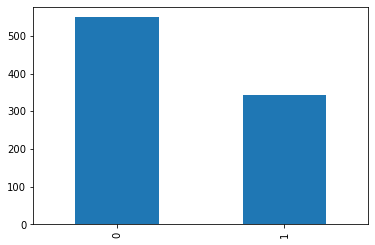

In [47]:
pd.value_counts(train['Survived']).plot.bar()

### The data is almost imbalanced. That's why i'm oversampling it.

In [48]:
# The ratio of X and 
over = RandomOverSampler(sampling_strategy=1)
X,y = over.fit_resample(X,y)

In [49]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [50]:
min_max = MinMaxScaler()
X_train_scaled = min_max.fit_transform(X_train)
X_test_scaled = min_max.transform(X_test)
# train = pd.DataFrame(scaled_data_train,columns=train.columns)

# scaled_data_test = min_max.fit_transform(test)
# test = pd.DataFrame(scaled_data_test,columns=test.columns)

[0.05654269 0.01517929 0.00541434 0.00489561 0.11600718 0.07214657
 0.05571238 0.02043381 0.15079467 0.05634382 0.00222904 0.01306849
 0.03778644 0.00728553 0.37810571 0.00475441 0.00330001]


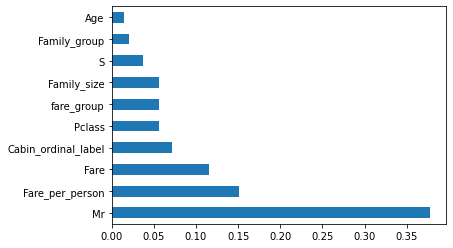

In [51]:
tree_reg = ExtraTreeClassifier()
tree_reg.fit(X,y)
print(tree_reg.feature_importances_)

#Top 5 important feature
features_importance = pd.Series(tree_reg.feature_importances_,index=X.columns)
features_importance.nlargest(10).plot(kind='barh')
plt.show()

These are the features which are affecting the target varibale the most.

# Training model

In [52]:
model = RandomForestClassifier()
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Cross validation

In [53]:
cv = StratifiedShuffleSplit(n_splits = 10, test_size = .25, random_state = 42 )
model_cv = RandomizedSearchCV(estimator=model,param_distributions=random_grid,scoring='accuracy',cv=cv,random_state = 42,n_iter=10)

model_cv.fit(X,y)

RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.25,
            train_size=None),
                   estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='accuracy')

In [55]:
model_cv.best_params_

{'n_estimators': 1800,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

# Testing data

In [56]:
model = RandomForestClassifier(n_estimators = 1800,
                                 min_samples_split = 5,
                                 min_samples_leaf =  1,
                                 max_features =  'auto',
                                 max_depth = 100,
                                 bootstrap = True)


model.fit(X_train_scaled,y_train)
y_pred = model.predict(X_test_scaled)

# Checking accuracy score

In [57]:
accuracy_score(y_test,y_pred)

0.85

Our model is 85% accurate.

In [58]:
from sklearn.metrics import classification_report, balanced_accuracy_score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       103
           1       0.88      0.83      0.85       117

    accuracy                           0.85       220
   macro avg       0.85      0.85      0.85       220
weighted avg       0.85      0.85      0.85       220



In [59]:
import pickle
pickle.dump(model,open('titanic.pkl','wb'))

In [ ]:
pd.set_option('display.max_columns',None)